In [1]:
import json, os, pickle, random
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

import qiskit
from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.circuit.library import CXGate, RXGate, IGate, ZGate
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)

from mlp import MLP1, MLP2, MLP3, encode_data

from mbd_utils import cal_z_exp, generate_disorder, construct_mbl_circuit, calc_imbalance, modify_and_add_noise_to_model

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def fix_random_seed(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print(f'random seed fixed to {seed}')

In [3]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [88]:
backend = FakeLima()
properties = get_backend_properties_v1(backend)

# Local, coherent noise
backend_ideal = QasmSimulator() # Noiseless
backend_noisy_coherent, noise_model = modify_and_add_noise_to_model()

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy_coherent = {'shots': 10000, 'backend': backend_noisy_coherent, 'name': 'noisy_coherent'}

In [4]:
def load_circuits(data_dir, f_ext='.json'):
    circuits = []
    ideal_exp_vals = []
    noisy_exp_vals = []
    data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(f_ext)]
    for data_file in tqdm(data_files, leave=True):
        if f_ext == '.json':
            for entry in json.load(open(data_file, 'r')):
                circuits.append(QuantumCircuit.from_qasm_str(entry['circuit']))
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
        elif f_ext == '.pk':
            for entry in pickle.load(open(data_file, 'rb')):
                circuits.append(entry['circuit'])
                ideal_exp_vals.append(entry['ideal_exp_value'])
                noisy_exp_vals.append(entry['noisy_exp_values'])
    return circuits, ideal_exp_vals, noisy_exp_vals

In [8]:
train_circuits, train_ideal_exp_vals, train_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_circuits/train/', '.pk')
print(len(train_circuits))

test_circuits, test_ideal_exp_vals, test_noisy_exp_vals = load_circuits('./data/haoran_mbd/random_circuits/val/', '.pk')
print(len(test_circuits))

  0%|          | 0/10 [00:00<?, ?it/s]

5000


  0%|          | 0/10 [00:00<?, ?it/s]

2000


In [102]:
# with open('./data/mbd_datasets2/theta_0.05pi/circuits.pk', 'rb') as infile:
#     loaded = pickle.load(infile)
#
# train_circuits = loaded['train_circuits']
# test_circuits = loaded['test_circuits']
# train_ideal_exp_vals = loaded['train_ideal_exp_vals']
# train_noisy_exp_vals = loaded['train_noisy_exp_vals']
# test_ideal_exp_vals = loaded['test_ideal_exp_vals']
# test_noisy_exp_vals = loaded['test_noisy_exp_vals']

In [9]:
num_qubit = 4
train_noisy_exp_vals = [x[0] for x in train_noisy_exp_vals]
test_noisy_exp_vals = [x[0] for x in test_noisy_exp_vals]
X_train, y_train = encode_data(train_circuits, properties, train_ideal_exp_vals, train_noisy_exp_vals, num_qubits=num_qubit)
X_test, y_test = encode_data(test_circuits, properties, test_ideal_exp_vals, test_noisy_exp_vals, num_qubits=num_qubit)

In [10]:
BATCH_SIZE = 32
fix_random_seed(0)
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

random seed fixed to 0


In [17]:
X_train = pd.DataFrame(X_train).iloc[:, -4:]
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (58).

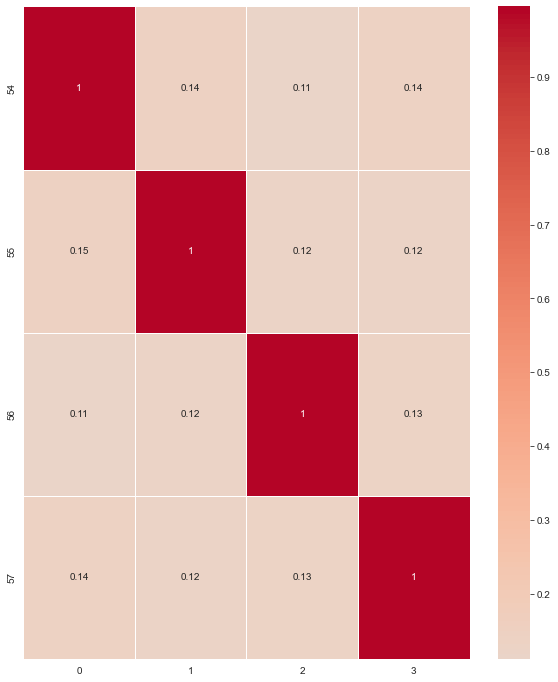

In [18]:
def correlation_map(X, y):
    corr_matrix = np.zeros((X.shape[1], y.shape[1]))
    for i, x_col in enumerate(X.columns):
        for j, y_col in enumerate(y.columns):
            corr_matrix[i, j] = X[x_col].corr(y[y_col])

    return pd.DataFrame(corr_matrix, index=X.columns, columns=y.columns)

correlations = correlation_map(X_train, y_train)

plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(10, 12))
sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, linewidths=.5)
yticklabels = ['cx_error', 'id_error', 'sx_error', 'x_error', 'rz error', 'readout_error', 't1', 't2']
yticklabels += [x+'_counts' for x in sorted(properties['gates_set'])]
bin_size = 0.1 * np.pi
num_angle_bins = int(np.ceil(4 * np.pi / bin_size))
yticklabels += ['rz_binned_counts'] * num_angle_bins
yticklabels += [f'noisy_exp_value_{i}' for i in range(4)]
plt.yticks(ticks=plt.yticks()[0], labels=yticklabels)
xticklabels = [f'ideal_exp_value_{i}' for i in range(4)]
plt.xticks(ticks=plt.xticks()[0], labels=xticklabels)
plt.title('Correlation Map between Features and the Targets (Ideal Exp Values)')
plt.show()

In [19]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [26]:
# ols_list = []
# for q in range(4):
#     ols = LinearRegression()
#     ols.fit(X_train, y_train.iloc[:, q])
#     ols_list.append(ols)

In [20]:
# with open('./model/random_circuits/ols.pk', 'wb') as f:
#     pickle.dump(ols, f)

In [58]:
"""Why OLS works"""
for batch_X, batch_y in test_loader:
    X = pd.DataFrame(batch_X)
    y = pd.DataFrame(batch_y)
    # y['trotter_steps'] = round(X.iloc[:, 8] * 100 / 6, 0)
    y['floquet_steps'] = round(X.iloc[:, 8] * 100 / 3, 0)

X.iloc[:, 8] = round(X.iloc[:, 8] * 100 / 3, 0)
# X.iloc[:, 8] = round(X.iloc[:, 8] * 100 / 6, 0)
X = X.sort_values(by=8)
X_noisy_exp_vals = X.groupby(by=8).agg('mean').iloc[:, -4:]
X_noisy_exp_vals.index.names = ['floquet_steps']
X_noisy_exp_vals.rename(columns={54: 0, 55: 1, 56: 2, 57: 3}, inplace=True)
X_noisy_exp_vals

,0,1,2,3
floquet_steps,,,,
0.0,0.842023,-0.977444,0.917805,-0.985487
1.0,0.755979,-0.886315,0.920661,-0.970377
2.0,0.723197,-0.820057,0.898840,-0.949496
3.0,0.695763,-0.780630,0.877226,-0.933695
4.0,0.673434,-0.698600,0.855048,-0.908412
5.0,0.647078,-0.681188,0.834377,-0.912441
6.0,0.621561,-0.690917,0.816185,-0.898381
7.0,0.602697,-0.657218,0.796658,-0.852125
8.0,0.586019,-0.615311,0.778177,-0.871560


In [59]:
y_ideal_exp_vals = y.groupby('floquet_steps').agg('mean')
y_ideal_exp_vals

,0,1,2,3
floquet_steps,,,,
0.0,1.000000,-1.000000,1.000000,-1.000000
1.0,0.987634,-0.951493,0.999698,-0.987662
2.0,0.981250,-0.879935,0.998192,-0.969056
3.0,0.976761,-0.853369,0.996751,-0.956354
4.0,0.979492,-0.762897,0.994293,-0.932196
5.0,0.979879,-0.760105,0.992972,-0.939718
6.0,0.981477,-0.793697,0.993993,-0.927763
7.0,0.978101,-0.764065,0.993552,-0.879097
8.0,0.977439,-0.715540,0.992681,-0.905180


In [60]:
for i in range(4):
    try: print(f'({i}, sx)', backend.properties().gate_error('sx', i))
    except: pass
    for j in range(4):
        try: print(f'({i}, {j})', backend.properties().gate_error('cx', [i, j]))
        except: pass

(0, sx) 0.00019195510390342677
(0, 1) 0.008339674869236618
(1, sx) 0.00033064681663890665
(1, 0) 0.008339674869236618
(1, 2) 0.005961828308163608
(1, 3) 0.009799775939734023
(2, sx) 0.0001807726361160903
(2, 1) 0.005961828308163608
(3, sx) 0.0003925363414603665
(3, 1) 0.009799775939734023


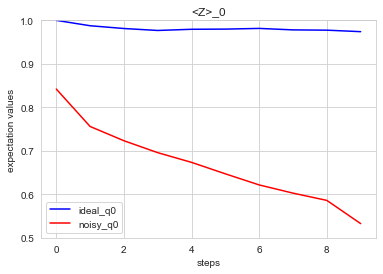

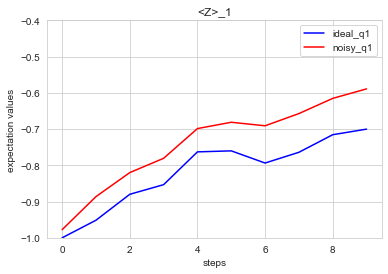

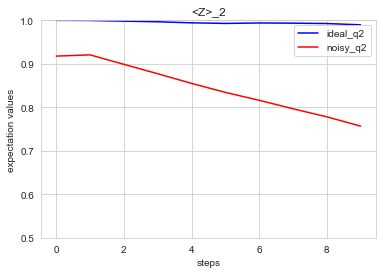

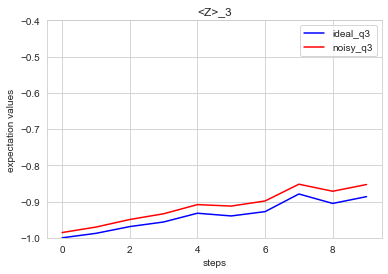

In [61]:
plt.style.use({'figure.facecolor':'white'})
for q in range(4):
    plt.figure()
    sns.lineplot(y_ideal_exp_vals, x='floquet_steps', y=q, label=f'ideal_q{q}', color='blue')
    sns.lineplot(X_noisy_exp_vals, x='floquet_steps', y=q, label=f'noisy_q{q}', color='red')
    # ymin, ymax = plt.gca().get_ylim()
    # plt.ylim([ymin, ymax])
    # plt.vlines(x=4, ymin=ymin, ymax=ymax, color='gray', label = 'train stops')
    plt.legend()
    # plt.ylim([-0.35, 0.35])
    if q%2 == 0: plt.ylim([0.5, 1])
    else: plt.ylim([-1, -0.4])
    plt.title(f'<Z>_{q}')
    # plt.xlabel('2q gate counts')
    plt.xlabel('steps')
    plt.ylabel('expectation values')
    plt.show()

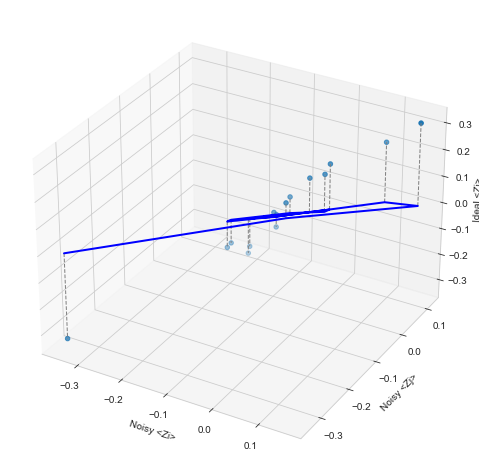

In [106]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

A = y_ideal_exp_vals.iloc[:, 0]
B = X_noisy_exp_vals.iloc[:, 0]
C = X_noisy_exp_vals.iloc[:, 1]
ax.scatter(B, C, A, marker='o')

for b, c, a in zip(B, C, A):
    ax.plot([b, b], [c, c], [0, a], color='gray', linestyle='--', linewidth=1)

plt.style.use({'figure.facecolor':'white'})
ax.plot(B, C, np.zeros_like(A), color='blue', linewidth=2)

ax.set_xlabel('Noisy <Zi>')
ax.set_ylabel('Noisy <Zj>')
ax.set_zlabel('Ideal <Zi>', labelpad=1)
fig.subplots_adjust(left=0.2, bottom=0.2, right=1, top=1)
plt.show()

random seed fixed to 0
RMSE_noisy_0: 0.008277381476612864
RMSE_mitigated_0: 0.0029808222489671227
RMSE_noisy_1: 0.008704420881402886
RMSE_mitigated_1: 0.003341787512146524
RMSE_noisy_2: 0.0089934359233761
RMSE_mitigated_2: 0.003310089734652082
RMSE_noisy_3: 0.008736577016868943
RMSE_mitigated_3: 0.00312353222038232
RMSE_noisy: 0.0086779538245652
RMSE_mitigated: 0.003189057929037012


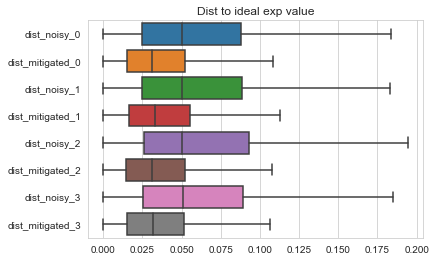

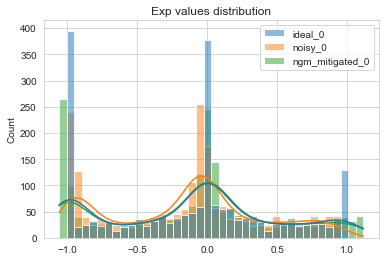

In [27]:
fix_random_seed(0)

distances = []

num_spins = 4
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

for batch_X, batch_y in test_loader:
    out = ols.predict(batch_X[:, -4:])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -4:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        for q in range(4):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
                "imb_ideal": imbalance_ideal,
                "imb_noisy": imbalance_noisy,
                "imb_ngm": imbalance_mitigated,
                "imb_diff": imbalance_ideal - imbalance_mitigated
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(4):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(4)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(4)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

# sns.histplot([df['imb_ideal'], df['imb_noisy'], df["imb_ngm"]], kde=True, bins=40)
# plt.title("Exp values distribution")
# plt.show()
#
# sns.histplot(data=df["imb_diff"], kde=True, bins=40)
# plt.title("Dist to ideal exp value")
# plt.show()

In [112]:
## Now we need to average over many disorders
num_disorders = 10

num_spins = 4 # Number of spins. Must be even.
W = 0.8 * np.pi # Disorder strength up to np.pi
theta = 0.05 * np.pi # Interaction strength up to np.pi
max_steps = 10

even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm(range(num_disorders)):
    disorders = generate_disorder(num_spins, W)
    # print(disorders)

    qc_list = []
    for steps in range(max_steps):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy_coherent, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy_coherent)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []

    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)

        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        # print(entry.batch)
        X, _ = encode_data([transpiled_qc_list[i]], properties, ideal_exp_val, [noisy_exp_val], num_qubits=4)
        mitigated_exp_val = ols.predict(X[:, -4:]).tolist()[0]

        exp_Z_mitigated.append(mitigated_exp_val)

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

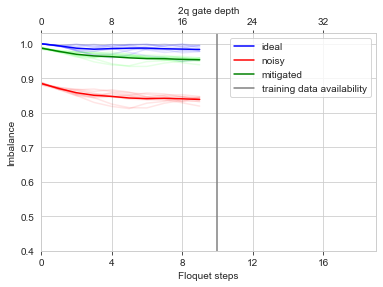

In [113]:
## Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for disorder_realization in range(num_disorders):
    ax1.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    ax1.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    ax1.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

ax1.plot(imbalance_ideal_average, color='blue', label="ideal")
ax1.plot(imbalance_noisy_average, color='red', label="noisy")
ax1.plot(imbalance_mitigated_average, color='green', label="mitigated")

ax1.axvline(x = 10, color = 'gray', label = 'training data availability')

ax1.set_xlabel('Floquet steps')
ax1.set_ylabel('Imbalance')
ax1.legend()

xmin,xmax = ax1.get_xlim()
max_x = max_steps + 10
ax1.set_xlim([0, max_x-1])
ax2.set_xlim([0, max_x-1])
ax1.set_ylim([0.4, 1.03])
ax1.set_xticks(np.arange(0, max_x, 4))
x2 = np.linspace(xmin, xmax, 50)
ax2.plot(x2, -np.ones(50)) # Create a dummy plot
ax2.set_xticks(np.arange(0, max_x, 4))
ax2.set_xticklabels(2*np.arange(0, max_x, 4))
ax2.set_xlabel(r"2q gate depth")
# ax1.grid(None)
ax2.grid(None)

plt.style.use({'figure.facecolor':'white'})
plt.show()

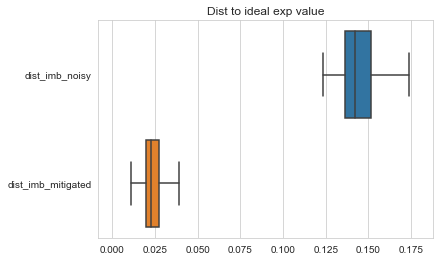

In [135]:
plt.style.use({'figure.facecolor':'white'})

num_spins = 8
even_qubits = np.linspace(0, num_spins, int(num_spins / 2), endpoint=False)
odd_qubits = np.linspace(1, num_spins + 1, int(num_spins / 2), endpoint=False)

distances = []
for batch_X, batch_y in test_loader:
    out = ols.predict(batch_X[:, :])

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -8:].tolist(),
        out.tolist()
    ):
        imbalance_ideal = calc_imbalance([ideal], even_qubits, odd_qubits)[0]
        imbalance_noisy = calc_imbalance([noisy], even_qubits, odd_qubits)[0]
        imbalance_mitigated = calc_imbalance([ngm_mitigated], even_qubits, odd_qubits)[0]
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
            "dist_imb_noisy": np.abs(imbalance_ideal - imbalance_noisy),
            "dist_imb_mitigated": np.abs(imbalance_ideal - imbalance_mitigated)
        })

df = pd.DataFrame(distances)

plt.figure()
sns.boxplot(data=df[["dist_imb_noisy", "dist_imb_mitigated"]], orient="h", showfliers = False)
plt.xlim([-0.008, 0.188])
plt.title("Dist to ideal exp value")
plt.show()

# plt.figure()
# sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=140)
# plt.xlim([-0.19, 0.63])
# plt.title("Exp values distribution")
# plt.show()